# Tutorial for CuNA 

CuNA has two parts to it: 
1. computing redescription groups by cumulants and 
2. performing network analysis after forming a network from the redescription groups.

In [1]:
%cd "/home/abose/PD/new/Geno4SD-Innersource/"
import pandas as pd 
import numpy as np 
import os, sys, time, random, math
from geno4sd.topology.CuNA import cumulants, cuna, cures

import matplotlib.pyplot as plt
import seaborn as sns
#warnings.filterwarnings('ignore')


/home/abose/PD/new/Geno4SD-Innersource


### Read data
We use a sample data from TCGA Breast cancer study. We have selected a subset of mRNAs, miRNAs and proteins which are associated with breast cancer in this data. 

In [67]:
path = '/home/abose/PD/new/Data/'
df = pd.read_csv(path+'ppmi_features_toCuNA.csv')
df.index=df['PATNO']
y = df['Dx']

df.drop(['PATNO','Dx'], axis=1, inplace=True)
print("Number of individuals: ", df.shape[0])
print("Number of features: ", df.shape[1])


Number of individuals:  736
Number of features:  61


In [68]:
[x for x in df.columns]

['NP2WALK',
 'NP3KTRMR',
 'NP3PTRML',
 'NP3FTAPL',
 'NP1FATG',
 'NP3PTRMR',
 'NP2TRMR',
 'NP3BRADY',
 'NP2SWAL',
 'NP3POSTR',
 'NP3RIGRU',
 'NP2SALV',
 'NP3LGAGR',
 'NP3FTAPR',
 'PN3RIGRL',
 'NP3RTARU',
 'NP1URIN',
 'DxPro',
 'NP3PRSPL',
 'NP3PRSPR',
 'DYSKPRES',
 'NP3TTAPR',
 'Sex',
 'NP2HWRT',
 'NP1CNST',
 'NP3KTRML',
 'NP3RTALU',
 'Age',
 'NP3HMOVR',
 'NP1LTHD',
 'NP2SPCH',
 'NP3LGAGL',
 'NP3RIGLU',
 'NP3HMOVL',
 'NP3TTAPL',
 'NP1SLPD',
 'NP1PAIN',
 'NHY',
 'NP2FREZ',
 'NP1SLPN',
 'NP3RIGLL',
 'MTCH1',
 'DGCR8',
 'OVOL3',
 'RPL13A',
 'EIF3F',
 'OR4B1',
 'MAP4K2',
 'GREB1',
 'RP11-409K20.6',
 'MGST2',
 'MFAP3L',
 'RNF34',
 'TCEB1',
 'PFKFB3',
 'ZNF33B',
 'DNAJC12',
 'MLKL',
 'FAM131A',
 'SPTLC2',
 'CCDC85C']

### Computing Cumulants

In [69]:
beg_time = time.time()
cumulants_df, vec_df = cumulants.get_cumulants(df)
print("Time spent computing cumulants (mins): ", (time.time() - beg_time)/60)

Time spent computing cumulants (mins):  6.1827079574267065


In [70]:
filt_cumulants_df = cumulants_df[cumulants_df['P'] < 0.05]  
filt_vec_df = vec_df[vec_df.k.isin(list(filt_cumulants_df.index))]
print("Number of significant redescription groups: ", filt_vec_df.shape[0])

Number of significant redescription groups:  231310


In [27]:
beg_time = time.time()

cures_vec, res, assoc = cures.get_cures(filt_vec_df.set_index('k').T, 
                                        y, 
                                        verbose=1,               
                                        fit_cures=True)

print("Time spent computing cures (mins): ", (time.time() - beg_time)/60)


/home/abose/PD/Pkgs/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/abose/PD/Pkgs/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/abose/PD/Pkgs/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/abose/PD/Pkgs/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/abose/PD/Pkgs/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: Converge

Best performing logistic regression model on training data:  {'C': 10.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
-------------------------------------
Model fitting complete
-------------------------------------
True Positive(TP)  =  123
False Positive(FP) =  31
True Negative(TN)  =  43
False Negative(FN) =  3
-------------------------------------
ROC AUC score of fitted model on test data:  0.8072715572715572
-------------------------------------
F1 score of fitted model on test data:  0.8186666666666667
-------------------------------------

**************************************
Computing CuReS
**************************************
Fitting logistic regression after train-test split
Best performing logistic regression model on training data:  {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
CuReS prediction statistics
**************************************
-------------------------------------
Model fitting complete
---------------------------

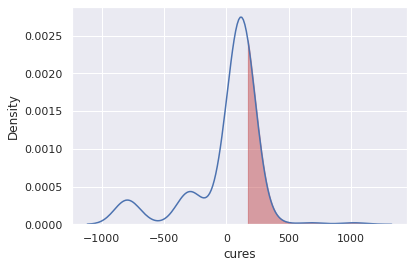

In [30]:
cures_vec_ = [x for sublist in list(cures_vec) for x in sublist]
cures_df = pd.DataFrame()
cures_df['cures'] = cures_vec_
cures_df['decile'] = pd.qcut(cures_df['cures'], 10, labels=False, duplicates='drop')

thres_decile = 9
nth_decile = np.min(cures_df[cures_df['decile'] >= thres_decile]['cures'])

fig = plt.figure(figsize=(6,4))
points = sns.kdeplot(data = cures_df, 
                     x='cures',
                     shade= False).get_lines()[0].get_data()

x1 = points[0]
y1 = points[1]

plt.fill_between(x1,y1, where = x1 > nth_decile, color='r', alpha=0.5)

In [31]:
fig.savefig("/home/abose/PD/new/Data/CuReSplot_mockdata_pheno0.png",
               dpi=600, bbox_inches='tight')

In [7]:
cumulants_df.to_csv('test.csv', index=False)

#### The p-value input should be a list of p-values. 

In [60]:
#p-value threshold
p = [1e-5, 1e-6, 1e-7]

#percentage thresholds of` (0.9, 0.1)
cutofflist = np.linspace(0.9,0.1,17)

### Computing CuNA (Cumulant-based network analysis)
CuNA returns the following:
    1. A dataframe with edges in its rows and the connected vertices in columns along with the statistical significance (measured by p-value) from the Fisher Exact test. 
    2. **count** or weight of the edge. 
    3. A dataframe of varying row lengths (contains None for empty fields) with the community membership information for all the vertices. 
    4. A dataframe with node rank. A score indicating the importance of each vertex across different centrality measures. The lower the score means higher the importance. 

In [72]:
beg_time = time.time()
p = [1e-2, 1e-5, 1e-8]
interactions, nodes, communities, noderank = cuna.get_network(cumulants_df.copy(),
                                                              0, 
                                                              p, 
                                                              verbose=0)
print("Time spent computing CuNA network (mins): ", (time.time() - beg_time)/60)

Time spent computing CuNA network (mins):  60.88270440896352


Communities in the network

In [73]:
interactions.to_csv('/home/abose/PD/new/Data/cuna_ppmi_interactions_v4.csv', index=False)

Top 10 ranked nodes in the network

In [74]:
noderank.to_csv('/home/abose/PD/new/Data/cuna_ppmi_noderank_v4.csv', index=False)

In [75]:
nodes

array(['DGCR8', 'SPTLC2', 'RPL13A', 'TCEB1', 'ZNF33B', 'FAM131A',
       'DYSKPRES', 'DNAJC12', 'MAP4K2', 'MTCH1', 'NP2SPCH', 'NHY',
       'OVOL3', 'NP3BRADY', 'NP2WALK', 'NP2FREZ', 'NP3TTAPR', 'NP2SWAL',
       'EIF3F', 'NP3LGAGR', 'NP1FATG', 'GREB1', 'NP3PTRML', 'PFKFB3',
       'NP3FTAPL', 'NP3HMOVL', 'NP3KTRMR', 'NP3RIGRU', 'MGST2', 'MFAP3L',
       'RNF34', 'NP3LGAGL', 'NP1SLPD', 'MLKL', 'NP2SALV', 'NP3POSTR',
       'NP3PRSPR', 'NP3PTRMR', 'NP3KTRML', 'NP1SLPN', 'NP3HMOVR',
       'NP3PRSPL', 'NP3RTARU', 'NP1LTHD', 'NP1URIN', 'NP1PAIN', 'OR4B1',
       'NP2HWRT', 'Age', 'CCDC85C', 'RP11-409K20.6', 'NP2TRMR',
       'NP3RIGLU', 'NP1CNST', 'Sex', 'NP3FTAPR', 'PN3RIGRL', 'NP3RTALU',
       'NP3TTAPL', 'NP3RIGLL'], dtype=object)

In [79]:
set(communities.iloc[2,:])

{'NP1PAIN',
 'NP1SLPN',
 'NP1URIN',
 'NP3FTAPR',
 'NP3KTRML',
 'NP3KTRMR',
 'NP3PTRML',
 'NP3PTRMR',
 'NP3RTALU',
 None,
 'OR4B1'}

In [80]:
noderank.sort_values('Score')

,Node,Score
9,MTCH1,10.60
8,MAP4K2,10.60
2,RPL13A,11.40
5,FAM131A,12.20
3,TCEB1,14.60
18,EIF3F,14.80
1,SPTLC2,15.20
4,ZNF33B,15.40
7,DNAJC12,15.60
0,DGCR8,16.40
